In [1]:
import pandas as pd
from collections import Counter,defaultdict,OrderedDict
from itertools import combinations
import numpy as np 
from rpy2.robjects.packages import importr
from rpy2.robjects import r,IntVector
from rpy2.robjects.vectors import ListVector
from multiprocessing import Pool,cpu_count
import scipy.stats as st
import matplotlib.pyplot as plt
from scipy.special import binom
importr('SuperExactTest')
from functools import partial
#import SVH
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import numpy as np


%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#sns.set_style('white')
sns.set_context('talk')#, font_scale=1.5)
import matplotlib as mpl
mpl.rcParams.update({'text.usetex': False})
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [11]:
1

1

In [2]:
def pvalue_intersect(X):
    t,neighs,N = X
    lists = [neighs[node] for node in t]
    rlists = [IntVector(l) for l in lists]  
    inters = set(lists[0])
    for n in lists[1:]: inters = inters.intersection(n)
    inters = len(inters)  
    lengths = sorted(map(len,lists))
    d = OrderedDict(zip(map(str, range(len(rlists))), rlists))
    data = ListVector(d)
    pvalue = 0
    i = 0
    while(pvalue==0):
        res = r['supertest'](data,n=N)
        pvalue = list(dict(zip(res.names, list(res)))['P.value'])[-1]
        N+=1
        i+=1
        if i>5: break
    return list(dict(zip(res.names, list(res)))['P.value'])[-1]

def p_over(t):
    w,n,na,nb = t
    return st.hypergeom.sf(w-1,n,na,nb)

def p_appr(t):
    n12 = t[0]
    n = t[1]
    ns = np.array(t[2:])
    order = len(ns)
    p = st.binom.sf(n12-1,p=np.prod(ns/n),n=n)
    if p>=0:
        return p
    else:
        print(n12,n,ns)
        return p
    
def tpr(true,pred):
    return len(set(pred).intersection(true))/len(true)

def fdr(true,pred):
    return len(set(pred).difference(true))/len(pred)

def jaccard(true,pred):
    return len(set(true).intersection(pred))/len(set(true).union(pred))

In [3]:
def pvalue_intersect(X):
    t,neighs,N = X
    lists = [neighs[node] for node in t]
    rlists = [IntVector(l) for l in lists]  
    inters = set(lists[0])
    for n in lists[1:]: inters = inters.intersection(n)
    inters = len(inters)  
    lengths = sorted(map(len,lists))
    d = OrderedDict(zip(map(str, range(len(rlists))), rlists))
    data = ListVector(d)
    pvalue = 0
    i = 0
    while(pvalue==0):
        res = r['supertest'](data,n=N)
        pvalue = list(dict(zip(res.names, list(res)))['P.value'])[-1]
        N+=1
        i+=1
        if i>5: break
    return list(dict(zip(res.names, list(res)))['P.value'])[-1]

def p_over(t):
    w,n,na,nb = t
    return st.hypergeom.sf(w-1,n,na,nb)

def p_appr(t):
    n12 = t[0]
    n = t[1]
    ns = np.array(t[2:])
    order = len(ns)
    p = st.binom.sf(n12-1,p=np.prod(ns/n),n=n)
    if p>=0:
        return p
    else:
        print(n12,n,ns)
        return p
    
def tpr(true,pred):
    return len(set(pred).intersection(true))/len(true)

def fdr(true,pred):
    try:
        return len(set(pred).difference(true))/len(pred)
    except: return np.nan
def jaccard(true,pred):
    return len(set(true).intersection(pred))/len(set(true).union(pred))

def expand(x,order):
    return tuple(combinations(x,order))

def expand_filter(x,order,drop):
    return list(set(combinations(x,order)).difference(drop))

def tuple_to_validate(x,groups,N,deg_a):
    return tuple([groups[x],N])+tuple([deg_a[ii] for ii in x])

def get_svs(df,min_order=2,max_order=0,approximate=False):

    observables = df.groupby('b')['a'].apply(lambda x: tuple(sorted(x))).tolist()
    print(len(observables))
    
    if max_order!=0:
        max_order = min(max_order,max(map(len,observables)))
    else:
        max_order = max(map(len,observables))
        
    print(max_order)

    s_groups = []

    neigh_set_a_sub = dict(df.groupby('a')['b'].apply(list).reset_index().values)
    N = df.b.nunique()
    na = df.a.nunique()
    
    if approximate: deg_a = Counter(df.a)

    svh_dfs = []
    
    groups_higher_order = {}

    for order in list(range(min_order,max_order+1))[::-1]:

        print(order)
        expand_order = partial(expand,order=order) 
        
        order_obs = filter(lambda x: len(x)>=order,s_groups)
        #p = Pool(processes=cpu_count())
        B = (i for ii in map(expand_order,order_obs) for i in ii)
        drop = Counter(B)
        #p.close()
        
        expand_filter_order = partial(expand_filter,order=order,drop=drop)
        print('drop')
        if not approximate:
        
            groups = set()
            for l in (map(lambda x: tuple(combinations(x,order)), filter(lambda x: len(x)>=order,observables))): 
                for g in l: groups.add(g)
            groups = groups.difference(drop)
                    
        else:
            
            
            order_obs = filter(lambda x: len(x)>=order,observables)
            #p = Pool(processes=cpu_count())
            B = (i for ii in map(expand_order,order_obs) for i in ii)
            groups = Counter(B)
            for g in drop: del groups[g]
            #p.close()

            #p.close()
            #groups = {i: groups[i] for i in groups if i not in drop}
            #for i in drop: del groups[i]
        print(len(groups))
        print('dropped')

        #print(len(groups))
        p = Pool(processes=cpu_count())
        if not approximate:

            pvalues = dict(zip(groups,p.map(pvalue_intersect,zip(groups,[neigh_set_a_sub]*len(groups),[N]*len(groups)))))
        else:
            pvalues = dict(zip(groups,p.map(p_appr,[tuple([groups[i],N])+tuple([deg_a[ii] for ii in i]) for i in groups])))

            #tuple_to_validate_order = partial(tuple_to_validate,groups=groups,N=N,deg_a=deg_a)
            #params = p.map(tuple_to_validate_order,groups)
            #pvalues = dict(zip(groups,p.map(p_appr,params)))
            
        p.close()

        n_possible = binom(na,order)
        bonf = 0.01/n_possible

        temp_df = pd.DataFrame(pvalues.items())
        #print(temp_df)
        try:
            temp_df.columns = ['group','pvalue']
        except: temp_df = pd.DataFrame(columns=['group','pvalue'])
        #print(temp_df.pvalue.min())
        ps = np.sort(temp_df.pvalue)
        k = np.arange(1,len(ps)+1)*bonf
        try: fdr = k[ps<k][-1] 
        except: fdr = 0
        if approximate: temp_df['w'] = temp_df.group.apply(lambda x: groups[x])
        temp_df['fdr'] = temp_df['pvalue']<bonf

        svh_dfs.append(temp_df)#.query('fdr'))
        
        print(len(groups_higher_order),temp_df.fdr.sum())

        s_groups_order = temp_df.query('fdr').group.tolist()

        s_groups.extend(s_groups_order)

    return pd.concat(svh_dfs)

In [4]:
100/binom(1000,2)

0.0002002002002002002

In [4]:
N = 1000
k=50
max_order = 6
closure = 0.5

def bench(N,k,max_order,closure,max_size=10,n_interactions=20):

    groups = []
    for order in range(2,max_order+1):

        t = int(binom(order+1,order))
        kk = int(k/t)
        if kk==0: print('warning')
        closed = 0
        all_g = 0
        for _ in range(int(closure*kk)):
                larger_g = tuple(sorted(np.random.choice(range(N),replace=False,size=order+1)))
                groups.extend(combinations(larger_g,order))
                closed+=t
                all_g+=t
        for _ in range(int((1-closure)*kk)):
                for __ in range(t):
                    groups.append(tuple(sorted(np.random.choice(range(N),replace=False,size=order))))
                    all_g+=1
                    
    for order in range(2,max_order+1):
        larger_g = set()
        for l in map(lambda x: tuple(combinations(x,order)),filter(lambda x: len(x)>order,groups)):
            for g in l: larger_g.add(g)
        groups = list(filter(lambda x: (x not in larger_g),groups ))

    groups = list(set(groups))  

    interactions = []
    for g in groups:
        for _ in range(st.binom.rvs(p=.5,n=n_interactions)):
            size = np.random.choice(range(0,max_size+1-len(g)))
            interactions.append(g+tuple(np.random.choice(list(set(range(N)).difference(g)),replace=False,size=size)))       

    edges = []

    M = N

    for clique in interactions:
        for t in clique:
            edges.append((t,M))
        M+=1

    df = pd.DataFrame(edges,columns=['a','b'])
    return df,groups

In [5]:
np.random.randint(1,2)

1

In [6]:
np.random.randint(1,3)

1

## Test p-values

In [7]:
def max_list(x):
    try:
        return max(x)
    except ValueError:
        return 0
    
def pvalue_intersect(X):
    t,neighs,N = X
    lists = [neighs[node] for node in t]
    rlists = [IntVector(l) for l in lists]  
    inters = set(lists[0])
    for n in lists[1:]: inters = inters.intersection(n)
    inters = len(inters)  
    lengths = sorted(map(len,lists))
    d = OrderedDict(zip(map(str, range(len(rlists))), rlists))
    data = ListVector(d)
    pvalue = 0
    i = 0
    while(pvalue==0):
        res = r['supertest'](data,n=N)
        pvalue = list(dict(zip(res.names, list(res)))['P.value'])[-1]
        N+=1
        i+=1
        if i>5: break
    return list(dict(zip(res.names, list(res)))['P.value'])[-1]

def p_over(t):
    w,n,na,nb = t
    return st.hypergeom.sf(w-1,n,na,nb)

def p_appr(t):
    n12 = t[0]
    n = t[1]
    ns = np.array(t[2:])
    order = len(ns)
    p = st.binom.sf(n12-1,p=np.prod(ns/n),n=n)
    if p>=0:
        return p
    else:
        print(n12,n,ns)
        return p

In [8]:
b = 5
a = b

a = max([i for i in range(10)])

b,a

(5, 9)

In [9]:
pvalues = dict(zip(groups,map(pvalue_intersect,zip(groups,[neigh_set_a_sub]*len(groups),[N]*len(groups)))))

#pvalues_2 = dict(zip(groups,map(p_over,[(groups[i],N,deg_a[i[0]],deg_a[i[1]]) for i in groups])))

pvalues_3 = dict(zip(groups,map(p_appr,[(groups[i],N,deg_a[i[0]],deg_a[i[1]]) for i in groups])))

NameError: name 'groups' is not defined

In [77]:
results2 = []
for size in range(2,4):
    print(size)
    
    ps_appr = defaultdict(list)
    ps = defaultdict(list)
    p_hyp = defaultdict(list)

    for N in [500,1000,10000,100000]:
        for f in [0.01,0.1,1]:
            for _ in range(100):
                max_activity = f*N
                ns = [np.random.randint(1,max_activity)]
                for _ in range(size-1):
                    ns.append(np.random.randint(1,max(2,min(N-sum(ns),max_activity))))
                #ns = [np.random.randint(1,max_activity) for _ in range(size)]
                nall = np.random.randint(0,min(ns))
                ps_appr[N].append(p_appr([nall]+[N]+ns))

                neighs = {}#defaultdict(list)
                group = list(range(size))
                max_size = nall
                for i in group:
                    neighs[i] = list(range(nall))+list(range(max_size+1,max_size+ns[i]-nall+1))
                    max_size = max([max(neighs.get(a,[0])) for a in range(size)])
                ps[N].append(pvalue_intersect((group,neighs,N)))
                results2.append([size,N,f,nall,tuple(ns),ps[N][-1],ps_appr[N][-1]])
        #p_hyp[N].append(p_over([nall]+[N]+ns))
        

#groups,[neigh_set_a_sub]*len(groups),[N]*len(groups)

2
3


In [66]:
                max_activity = f*N
                ns = [np.random.randint(1,max_activity)]
                for _ in range(size):
                    ns.append(np.random.randint(1,max(2,min(N-sum(ns),max_activity))))
                #ns = [np.random.randint(1,max_activity) for _ in range(size)]
                nall = np.random.randint(0,min(ns))
                #ps_appr[N].append(p_appr([nall]+[N]+ns))

                neighs = {}#defaultdict(list)
                group = list(range(size))
                max_size = nall
                for i in group:
                    neighs[i] = list(range(nall))+list(range(max_size+1,max_size+ns[i]-nall+1))
                    max_size = max([max(neighs.get(a,[0])) for a in range(size)])
                #ps[N].append(pvalue_intersect((group,neighs,N)))
                

In [68]:
p_appr([nall]+[N]+ns),pvalue_intersect((group,neighs,N))

(4.581615450052323e-143, 1.0)

In [73]:
ns

[78993, 9342, 6759, 2573]

In [69]:
nall

186

In [72]:
len(set(neighs[0]).intersection(neighs[1]).intersection(neighs[2]).intersection()

186

In [76]:
len(neighs[0]),len(neighs[1]),len(neighs[2])

(78993, 9342, 6759)

In [59]:
res.query('size==2 & nall>10')

,size,n,f,nall,values,p_real,p_appr
102,2,200,0.1,11,"(12, 12, 16)",3.695339e-16,4.171050e-22
206,2,200,1.0,16,"(50, 122, 18)",9.999997e-01,2.478654e-08
208,2,200,1.0,13,"(57, 31, 46)",5.918336e-02,1.861114e-07
210,2,200,1.0,11,"(14, 83, 37)",4.170856e-03,1.652360e-08
216,2,200,1.0,34,"(63, 77, 56)",2.017165e-03,1.294043e-14
...,...,...,...,...,...,...,...
1495,2,100000,1.0,1694,"(7687, 74484, 1979)",1.000000e+00,0.000000e+00
1496,2,100000,1.0,9881,"(47060, 10242, 27453)",0.000000e+00,0.000000e+00
1497,2,100000,1.0,3767,"(67901, 12708, 10041)",1.000000e+00,0.000000e+00
1498,2,100000,1.0,3286,"(13306, 13313, 15056)",9.881313e-324,0.000000e+00


In [65]:
(84027/100000)*(15208/100000)*(452/100000)

57.76029424319999

In [63]:
st.binom.sf(254,p=(84027/100000)*(15208/100000)*(452/100000),n=100000)

4.285420840384038e-81

In [61]:
res1 = pd.DataFrame(results,columns=['size','n','f','nall','values','p_real','p_appr'])

res1.query('f==0.01')

,size,n,f,nall,values,p_real,p_appr
0,2,200,0.01,0,"(1, 1)",1.000000e+00,1.000000e+00
1,2,200,0.01,0,"(1, 1)",1.000000e+00,1.000000e+00
2,2,200,0.01,0,"(1, 1)",1.000000e+00,1.000000e+00
3,2,200,0.01,0,"(1, 1)",1.000000e+00,1.000000e+00
4,2,200,0.01,0,"(1, 1)",1.000000e+00,1.000000e+00
...,...,...,...,...,...,...,...
5795,5,100000,0.01,11,"(85, 648, 15, 644, 294)",7.702730e-108,3.436431e-105
5796,5,100000,0.01,69,"(354, 546, 814, 513, 550)",0.000000e+00,0.000000e+00
5797,5,100000,0.01,76,"(252, 323, 242, 899, 411)",0.000000e+00,0.000000e+00
5798,5,100000,0.01,112,"(489, 717, 629, 811, 117)",0.000000e+00,0.000000e+00


In [78]:
res = pd.DataFrame(results2,columns=['size','n','f','nall','values','p_real','p_appr'])
res.to_csv('results/PvalueApprox2.csv',index=None)

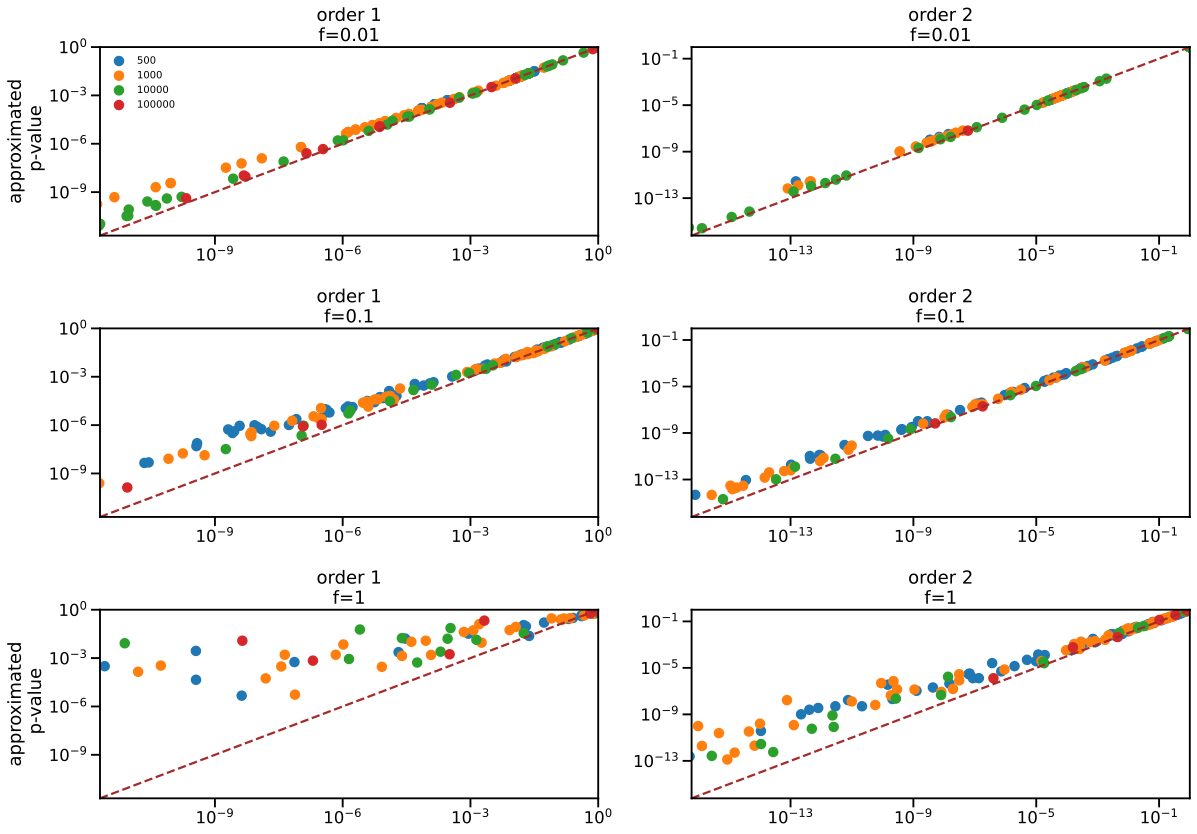

In [79]:
fig,axes = plt.subplots(3,2,figsize=(17,12))
axes = axes.flatten()

i = 0

for f in [0.01,0.1,1]:
    for size in range(2,4):
        ax = axes[i]
        sub = res.query('size==@size & f==@f')
        lim = 0.01/binom(sub.n.max(),size)
        for n in sorted(sub.n.unique()):
            ax.scatter(sub.query('n==@n').p_real,sub.query('n==@n').p_appr,label=n)

        ax.plot([lim,1],[lim,1],ls='--',color='brown')
        ax.set_xlim([lim,1])
        ax.set_ylim([lim,1])
        ax.set_xscale('log')
        ax.set_yscale('log')
        #ax.set_aspect('equal') 
        ff = str(f)[:4]
        ax.set_title('order {}\nf={}'.format(size-1,ff))
        if i==0:ax.legend(frameon=False,fontsize=10)
        if i in [0,4,8]: ax.set_ylabel('approximated\n p-value')
        if i>=8: ax.set_xlabel('exact p-value')
        i+=1
        if size==2:
            ax.set_yticks([1e-9,1e-6,1e-3,1])
            ax.set_xticks([1e-9,1e-6,1e-3,1])
        elif size==3:
            ax.set_yticks([1e-13,1e-9,1e-5,1e-1])
            ax.set_xticks([1e-13,1e-9,1e-5,1e-1])
        elif size==4:
            ax.set_yticks([1e-16,1e-11,1e-6,1e-1])
            ax.set_xticks([1e-16,1e-11,1e-6,1e-1])           
        elif size==5:
            ax.set_yticks([1e-19,1e-13,1e-7,1e-1])
            ax.set_xticks([1e-19,1e-13,1e-7,1e-1])
            
        
        #ax.set_xticks(ax.get_yticks())

plt.tight_layout()

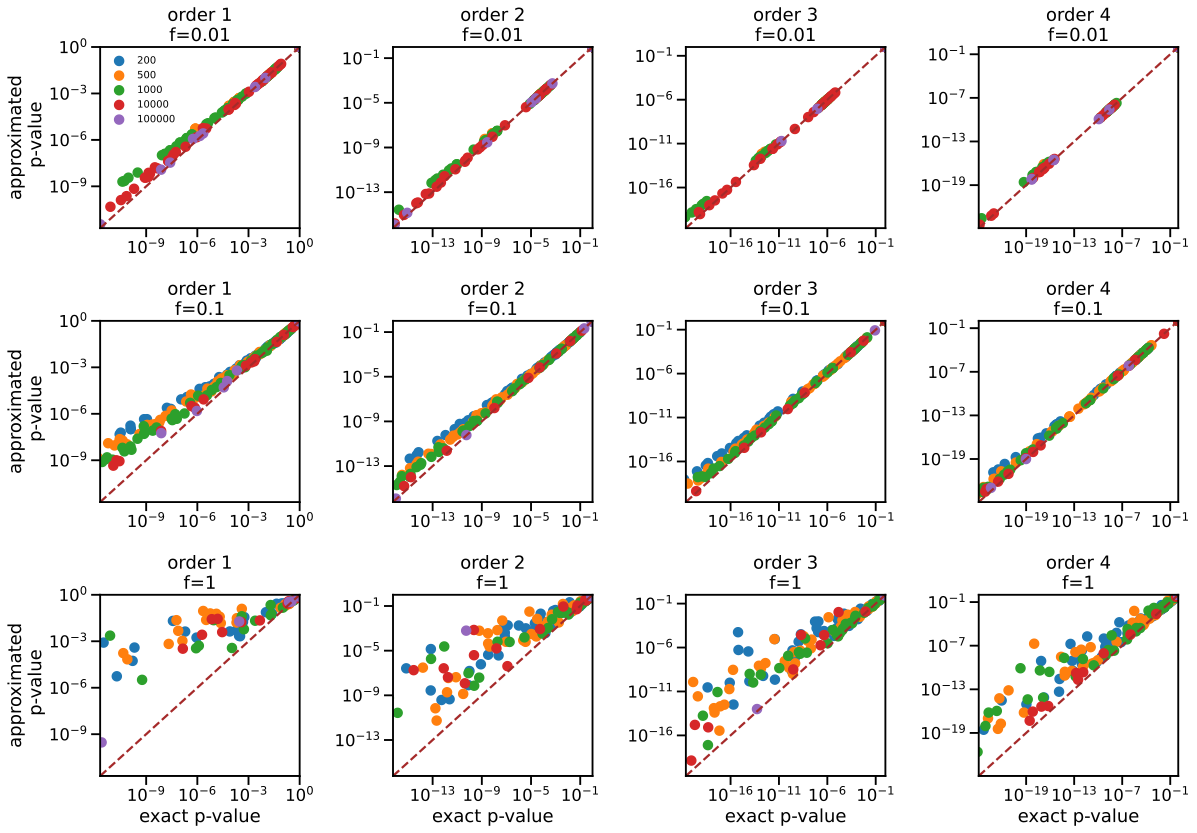

In [47]:
res = pd.DataFrame(results,columns=['size','n','f','nall','values','p_real','p_appr'])
res.to_csv('results/PvalueApprox.csv',index=None)

fig,axes = plt.subplots(3,4,figsize=(17,12))
axes = axes.flatten()

i = 0

for f in [0.01,0.1,1]:
    for size in range(2,6):
        ax = axes[i]
        sub = res.query('size==@size & f==@f')
        lim = 0.01/binom(sub.n.max(),size)
        for n in sorted(sub.n.unique()):
            ax.scatter(sub.query('n==@n').p_real,sub.query('n==@n').p_appr,label=n)

        ax.plot([lim,1],[lim,1],ls='--',color='brown')
        ax.set_xlim([lim,1])
        ax.set_ylim([lim,1])
        ax.set_xscale('log')
        ax.set_yscale('log')
        #ax.set_aspect('equal') 
        ff = str(f)[:4]
        ax.set_title('order {}\nf={}'.format(size-1,ff))
        if i==0:ax.legend(frameon=False,fontsize=10)
        if i in [0,4,8]: ax.set_ylabel('approximated\n p-value')
        if i>=8: ax.set_xlabel('exact p-value')
        i+=1
        if size==2:
            ax.set_yticks([1e-9,1e-6,1e-3,1])
            ax.set_xticks([1e-9,1e-6,1e-3,1])
        elif size==3:
            ax.set_yticks([1e-13,1e-9,1e-5,1e-1])
            ax.set_xticks([1e-13,1e-9,1e-5,1e-1])
        elif size==4:
            ax.set_yticks([1e-16,1e-11,1e-6,1e-1])
            ax.set_xticks([1e-16,1e-11,1e-6,1e-1])           
        elif size==5:
            ax.set_yticks([1e-19,1e-13,1e-7,1e-1])
            ax.set_xticks([1e-19,1e-13,1e-7,1e-1])
            
        
        #ax.set_xticks(ax.get_yticks())

plt.tight_layout()
plt.savefig('figures/PvalueAnalysis.png',dpi=300)

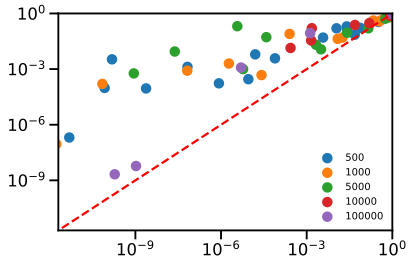

In [288]:
m = 1
B = 1
for N in ps_appr:
    bonf = 0.01/binom(N,size)
    x = ps[N]
    y = ps_appr[N]
    plt.scatter(x,y,label=N)
    #t = min(min(list(filter(lambda x: x>0,x))),min(list(filter(lambda x: x>0,y))))
    if m>t: m=t
    if B>bonf: B=bonf
plt.plot([0,1],[0,1],ls='--',color='red')

#m = 1e-60
    
plt.legend(frameon=False,fontsize=10)
plt.xlim([B,1])
plt.ylim([B,1])
#plt.axvline(x=B)
#plt.axhline(y=B)#
plt.yscale('log')
plt.xscale('log')

In [276]:
plt.scatter

5

In [ ]:
x = p_s
y = p_a
plt.scatter(x,y,label=N)

plt.plot([0,1],[0,1],ls='--',color='red')
plt.yscale('log')
plt.xscale('log')
plt.xlim([1e-50,1])
plt.ylim([1e-50,1])

In [203]:
df = pd.read_csv('sampleValues.csv').values

In [241]:
(df[:,0]/(df[:,2:4].min(axis=1))).max()

0.9667063020214031

In [244]:
(df[:,0]/(df[:,1])).max()

0.017141860667887348

In [ ]:
(df[:,0]/(df[:,1])).max()

In [245]:
((df[:,2:4].min(axis=1))/df[:,1]).max()

0.023320835876420497

In [246]:
((df[:,2:4].max(axis=1))/df[:,1]).max()

0.026128404103816085

In [218]:
p_s = []
p_a = []
p_h = []

for t in df:
    
    ns = list(map(int,t[2:]))
    nall = int(t[0])
    N = int(t[1])
    
    p_a.append(p_appr([nall]+[N]+ns))

    neighs = {}#defaultdict(list)
    group = list(range(size))
    max_size = nall
    for i in group:
        neighs[i] = list(range(nall))+list(range(max_size+1,max_size+ns[i]-nall+1))
        max_size = max([max(neighs.get(a,[0])) for a in range(size)])
    #ps[N][(N,tuple(ns),nall)] = 
    p_s.append(pvalue_intersect((group,neighs,N)))
    #p_hyp[N][(N,tuple(ns),nall)] = 
    p_h.append(p_over([nall]+[N]+ns))

(1e-50, 1)

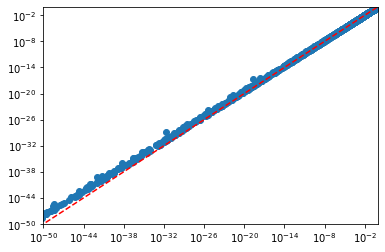

In [231]:
x = p_s
y = p_a
plt.scatter(x,y,label=N)

plt.plot([0,1],[0,1],ls='--',color='red')
plt.yscale('log')
plt.xscale('log')
plt.xlim([1e-50,1])
plt.ylim([1e-50,1])

In [224]:
df

array([[  1667, 172035,   3885,   4012],
       [   183, 172035,    367,    478],
       [    85, 172035,    343,   1133],
       ...,
       [     1, 172035,    109,    926],
       [     1, 172035,    536,   1518],
       [     1, 172035,   1868,   1834]])

In [211]:
nall

1

In [212]:
group

[0, 1]

In [213]:
len(neighs[0]),len(neighs[1])

(1868, 1834)

In [214]:
len(set(neighs[0]).intersection(neighs[1]))

1

In [192]:
        ns = [np.random.randint(1,N) for _ in range(size)]
        nall = np.random.randint(0,min(ns))
        ps_appr[N][(N,tuple(ns),nall)] = p_appr([nall]+[N]+ns)
        
        neighs = {}#defaultdict(list)
        group = list(range(size))
        max_size = nall
        for i in group:
            neighs[i] = list(range(nall))+list(range(max_size+1,max_size+ns[i]-nall+1))
            max_size = max([max(neighs.get(a,[0])) for a in range(size)])
        ps[N][(N,tuple(ns),nall)] = pvalue_intersect((group,neighs,N))
        p_hyp[N][(N,tuple(ns),nall)] = p_over([nall]+[N]+ns)

In [193]:
p_appr([nall]+[N]+ns)

2.680641520944608e-276

In [194]:
st.binom.sf(nall-1,p=(len(neighs[0])/N)*(len(neighs[1])/N),n=max(len(neighs[0]),len(neighs[1])))

0.0

In [195]:
st.binom.sf(nall-1,p=len(neighs[0])*len(neighs[1])/(N**2),n=N)

2.680641520944608e-276

In [196]:
st.hypergeom.sf(nall-1,N,len(neighs[0]),len(neighs[1]))

0.0

In [197]:
pvalue_intersect((group,neighs,N))

0.0

In [215]:
len(neighs[0]),len(neighs[1]),len(neighs[2])

KeyError: 2

In [95]:
len(set(neighs[0]).intersection(neighs[1]).intersection(neighs[2]))

KeyError: 2

In [96]:
N

1000

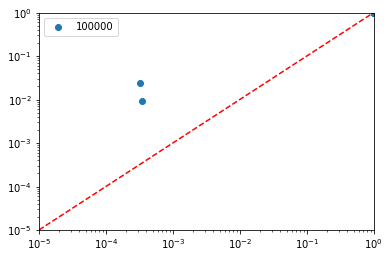

In [202]:
m = 1
for N in [100000]:
    
    x = [p_hyp[N][x] for x in sorted(ps[N])]
    y = [ps_appr[N][x] for x in sorted(ps[N])]
    plt.scatter(x,y,label=N)
    t = max(min(x),min(y))
    if m>t: m=t 
plt.plot([0,1],[0,1],ls='--',color='red')
    
plt.legend()
plt.xlim([1e-5,1])
plt.ylim([1e-5,1])
#plt.axvline(x=0)
plt.yscale('log')
plt.xscale('log')

In [199]:
sorted(ps[N])

[(100000, (2308, 53315), 2191),
 (100000, (2366, 13648), 253),
 (100000, (3952, 47120), 1379),
 (100000, (6638, 53807), 5791),
 (100000, (9086, 24054), 8890),
 (100000, (10934, 41324), 1471),
 (100000, (11667, 27614), 4224),
 (100000, (12896, 45999), 12315),
 (100000, (13214, 63557), 4472),
 (100000, (13580, 24106), 4326),
 (100000, (14725, 37955), 12503),
 (100000, (14836, 53750), 11915),
 (100000, (15786, 12415), 10621),
 (100000, (17329, 62794), 2265),
 (100000, (17910, 39389), 11117),
 (100000, (19399, 28578), 15078),
 (100000, (19491, 19389), 9168),
 (100000, (19496, 76716), 16519),
 (100000, (19994, 58766), 7681),
 (100000, (20011, 64944), 6926),
 (100000, (20480, 26077), 15845),
 (100000, (21662, 14347), 6650),
 (100000, (22538, 26288), 8752),
 (100000, (24722, 86818), 7893),
 (100000, (24833, 51001), 11360),
 (100000, (24836, 20658), 9741),
 (100000, (26233, 25375), 10903),
 (100000, (28321, 94869), 28003),
 (100000, (28357, 61791), 14086),
 (100000, (32217, 81563), 14104),
 (1

In [156]:
st.pearsonr(x,y)

(0.9980579880122588, 8.49695333321923e-125)

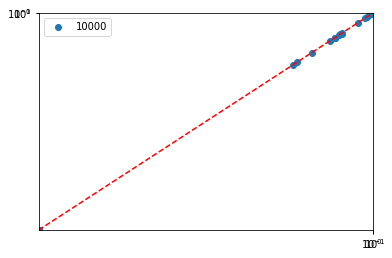

In [110]:
m = 1
for N in [10000]:
    
    x = [p_hyp[N][x] for x in sorted(ps[N])]
    y = [ps[N][x] for x in sorted(ps[N])]
    plt.scatter(x,y,label=N)
    t = max(min(x),min(y))
    if m>t: m=t 
plt.plot([0,1],[0,1],ls='--',color='red')
    
plt.legend()
plt.xlim([m,1])
plt.ylim([m,1])
#plt.axvline(x=0)
plt.yscale('log')
plt.xscale('log')

In [76]:
min(y)

4.692554494807421e-134

In [36]:
neighs[0]

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [ ]:
max_list

In [33]:
neighs

defaultdict(list, {0: [[0]], 1: [], 2: []})

In [8]:
N = 200
k= int(0.005*binom(N,2))
closure = 1
k

99

In [9]:
import igraph
import SVH

In [ ]:
max_size = 6
n_interactions = 20

for N in [100,200,500]:
    for density in [0.005,0.01,0.02]:
        #str_d = ''.join(str(d).split('.'))
        for closure in np.linspace(0,1,6):
            #str_c = ''.join(str(closure).split('.'))
            for _ in range(100):
                k= int(density*binom(N,2))
                df,groups = bench(N,k,4,closure,max_size=max_size,n_interactions=n_interactions)
                    
                svh = SVH.get_svh(df)
                svh_g = []
                for order in svh:
                    svh_g.extend(svh[order].query('fdr').group.tolist())

                true = groups
                pred = svh_g
                a = (tpr(true,pred))
                b = (fdr(true,pred))
                c = (jaccard(true,pred))
                
                with open('results/ResultBenchSVH_MaxSize{}_Nint{}.csv'.format(max_size,n_interactions),'a') as f:
                    f.write('{},{},{},{},{},{}\n'.format(N,density,closure,a,b,c))

In [ ]:
max_size = 6
n_interactions = 20

for N in [100,200,500]:
    for density in [0.005,0.01,0.02]:
        #str_d = ''.join(str(d).split('.'))
        for closure in np.linspace(0,1,6):
            #str_c = ''.join(str(closure).split('.'))
            for _ in range(100):
                k= int(density*binom(N,2))
                df,groups = bench(N,k,4,closure,max_size=max_size,n_interactions=n_interactions)

                dyads = groups#list(filter(lambda x: len(x)==3,groups))
                dd = []
                for d in dyads: dd.extend(list(combinations(d,2)))
                g = igraph.Graph(N,dd)
                lcc = max(map(len,(g.components())))
                with open('results/ResultBenchLCC_MaxSize{}_Nint{}_B.csv'.format(max_size,n_interactions),'a') as f:
                    f.write('{},{},{},{}\n'.format(N,density,closure,lcc))
                svn = SVH.get_svn(df)
                true = groups
                pred = list(map(lambda x: tuple(sorted(x)),svn.maximal_cliques(min=2)))
                a = (tpr(true,pred))
                b = (fdr(true,pred))
                c = (jaccard(true,pred))
                with open('results/ResultBenchSVN_MaxSize{}_Nint{}_B.csv'.format(max_size,n_interactions),'a') as f:
                    f.write('{},{},{},{},{},{}\n'.format(N,density,closure,a,b,c))
                    
                svs_approx = get_svs(df,approximate=True)
                true = groups
                pred = svs_approx.query('fdr').group
                a = (tpr(true,pred))
                b = (fdr(true,pred))
                c = (jaccard(true,pred))
                with open('results/ResultBenchSVS_MaxSize{}_Nint{}_B.csv'.format(max_size,n_interactions),'a') as f:
                    f.write('{},{},{},{},{},{}\n'.format(N,density,closure,a,b,c))
                    
                svh = SVH.get_svh(df)
                svh_g = []
                for order in svh:
                    svh_g.extend(svh[order].query('fdr').group.tolist())

                true = groups
                pred = svh_g
                a = (tpr(true,pred))
                b = (fdr(true,pred))
                c = (jaccard(true,pred))
                
                with open('results/ResultBenchSVH_MaxSize{}_Nint{}_B.csv'.format(max_size,n_interactions),'a') as f:
                    f.write('{},{},{},{},{},{}\n'.format(N,density,closure,a,b,c))

641
6
6
drop
155
dropped
0 0
5
drop
1080
dropped
0 0
4
drop
3054
dropped
0 20
3
drop
4263
dropped
0 24
2
drop
2226
dropped
0 8
694
6
6
drop
174
dropped
0 0
5
drop
1228
dropped
0 1
4
drop
3485
dropped
0 19
3
drop
4876
dropped
0 24
2
drop
2433
dropped
0 7
671
6
6
drop
166
dropped
0 0
5
drop
1182
dropped
0 0
4
drop
3379
dropped
0 21
3
drop
4731
dropped
0 23
2
drop
2375
dropped
0 8
682
6
6
drop
176
dropped
0 0
5
drop
1219
dropped
0 0
4
drop
3442
dropped
0 20
3
drop
4814
dropped
0 24
2
drop
2428
dropped
0 9
665
6
6
drop
187
dropped
0 0
5
drop
1280
dropped
0 0
4
drop
3574
dropped
0 21
3
drop
4951
dropped
0 23
2
drop
2503
dropped
0 10
681
6
6
drop
175
dropped
0 0
5
drop
1219
dropped
0 0
4
drop
3464
dropped
0 20
3
drop
4861
dropped
0 24
2
drop
2416
dropped
0 8
597
6
6
drop
135
dropped
0 0
5
drop
960
dropped
0 0
4
drop
2777
dropped
0 20
3
drop
3958
dropped
0 23
2
drop
2137
dropped
0 6
680
6
6
drop
173
dropped
0 0
5
drop
1230
dropped
0 0
4
drop
3528
dropped
0 20
3
drop
4965
dropped
0 24
2
drop
2

In [123]:
            dyads = groups#list(filter(lambda x: len(x)==3,groups))
            dd = []
            for d in dyads: dd.extend(list(combinations(d,2)))
            g = igraph.Graph(N,dd)
            print()

155


In [140]:
df,groups = bench(N,k,4,closure,max_size=6,n_interactions=20)


In [130]:
                svn = SVH.get_svn(df)
                true = groups
                pred = list(map(lambda x: tuple(sorted(x)),svn.maximal_cliques(min=2)))
                a = (tpr(true,pred))
                b = (fdr(true,pred))
                c = (jaccard(true,pred))
                a,b,c

(0.13793103448275862, 0.5121951219512195, 0.12048192771084337)

In [133]:
                svs_approx = get_svs(df,approximate=True)
                true = groups
                pred = svs_approx.query('fdr').group
                a = (tpr(true,pred))
                b = (fdr(true,pred))
                c = (jaccard(true,pred))
                a,b,c

2911
6
6
5
4
3
2


(0.8611111111111112, 0.015873015873015872, 0.8493150684931506)

In [112]:

print(tpr(true,pred))
print(fdr(true,pred))
print(jaccard(true,pred))

0.1111111111111111
0.6404494382022472
0.0927536231884058


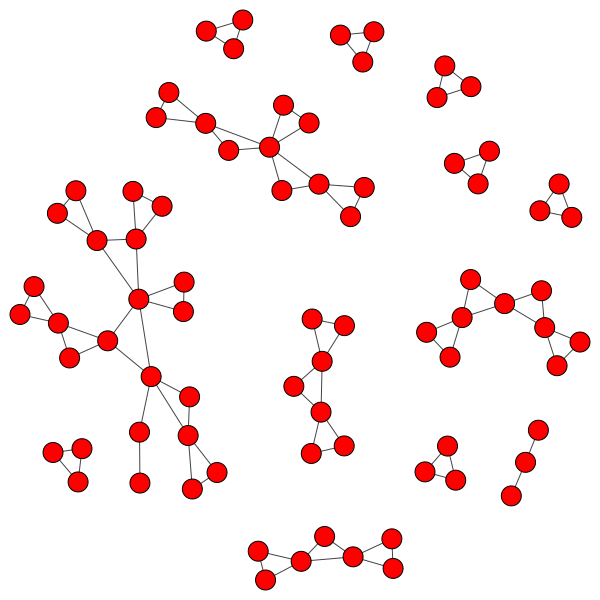

In [113]:
import igraph
dyads = list(filter(lambda x: len(x)==2,groups))
g = igraph.Graph(N,dyads)
keep = [i for i in range(g.vcount()) if g.degree()[i]>0]
igraph.plot(g.subgraph(keep))

In [114]:
Counter(map(len,g.subgraph(keep).components()))

Counter({21: 1, 11: 1, 7: 2, 3: 8, 9: 1})

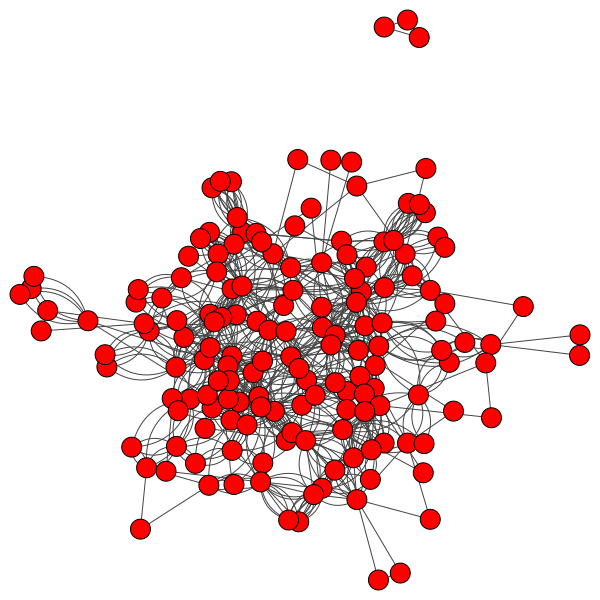

In [115]:
dyads = groups#list(filter(lambda x: len(x)==3,groups))
dd = []
for d in dyads: dd.extend(list(combinations(d,2)))
g = igraph.Graph(N,dd)
keep = [i for i in range(g.vcount()) if g.degree()[i]>0]
igraph.plot(g.subgraph(keep))

In [116]:
Counter(map(len,g.subgraph(keep).components()))

Counter({155: 1, 3: 1})

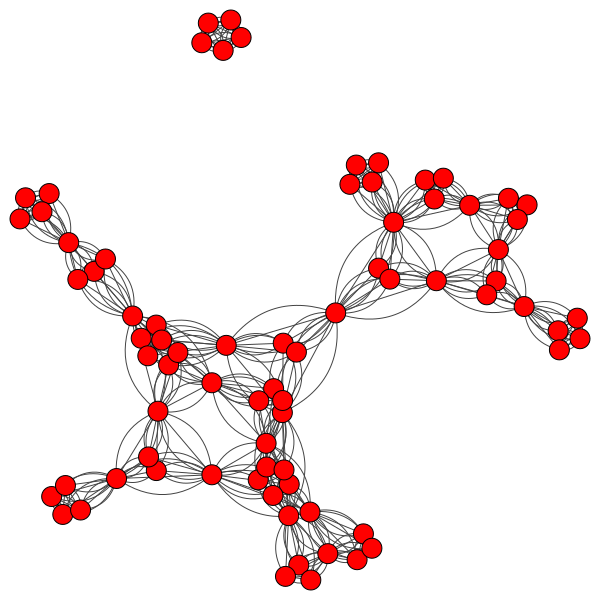

In [117]:
dyads = list(filter(lambda x: len(x)==4,groups))
dd = []
for d in dyads: dd.extend(list(combinations(d,2)))
g = igraph.Graph(N,dd)
keep = [i for i in range(g.vcount()) if g.degree()[i]>0]
igraph.plot(g.subgraph(keep))

In [118]:
Counter(map(len,g.subgraph(keep).components()))

Counter({71: 1, 5: 1})

In [119]:
svs_approx = get_svs(df,approximate=True)
true = groups
pred = svs_approx.query('fdr').group
print(tpr(true,pred))
print(fdr(true,pred))
print(jaccard(true,pred))

2835
6
6
5
4
3
2
0.84375
0.024096385542168676
0.826530612244898


In [141]:
svh = SVH.get_svh(df)
svh_g = []
for order in svh:
    svh_g.extend(svh[order].group.tolist())
    
true = groups
pred = svh_g
print(tpr(true,pred))
print(fdr(true,pred))
print(jaccard(true,pred))

0.9041095890410958
0.897116134060795
0.1017733230531997


0.0
1.0
0.0


In [46]:
a = {1:2,2:3}

In [49]:
a.popitem(1)

TypeError: dict.popitem() takes no arguments (1 given)

In [ ]:
1

In [117]:
a = list(filter(lambda x: len(x)==3,groups))
(svs_approx.query('group in @a'))

,group,pvalue,w,fdr
126,"(30, 52, 82)",2.770002e-21,12,True
309,"(55, 85, 96)",1.692313e-13,11,True
628,"(64, 67, 79)",1.856692e-11,10,True
660,"(64, 79, 80)",2.010636e-14,11,True
926,"(71, 82, 89)",2.636080e-19,9,True
1563,"(44, 46, 69)",2.686304e-13,12,True
1631,"(44, 57, 69)",1.300714e-07,8,True
1693,"(47, 64, 80)",7.274607e-15,11,True
1806,"(47, 79, 80)",5.906385e-14,13,True
1886,"(35, 49, 70)",6.047741e-08,8,True


In [50]:
dyad_groups = []
for g in groups:
    if len(g)==2: 1#dyad_groups.append(g)
    else: dyad_groups.extend(combinations(g,2))

In [51]:
dyad_svs_groups = []
for g in svs_approx.query('fdr').group:
    if len(g)==2: 1#dyad_groups.append(g)
    else: dyad_svs_groups.extend(combinations(g,2))

In [52]:
len(set(groups).intersection(dyad_svs_groups))

0

In [53]:
a = list(filter(lambda x: len(x)==2,groups))
(svs_approx.query('group in @a'))#.pvalue.min()

,group,pvalue,w,fdr
1,"(14, 18)",0.077760,20,False
2,"(14, 20)",0.861080,12,False
13,"(63, 98)",0.002134,26,False
43,"(44, 63)",0.209646,24,False
55,"(55, 66)",0.959039,10,False
...,...,...,...,...
3616,"(9, 88)",0.563178,19,False
3652,"(39, 74)",0.800636,10,False
3657,"(25, 99)",0.069426,18,False
3664,"(31, 54)",0.880209,13,False


In [54]:
Counter(df.groupby('b')['a'].count())

Counter({4: 3564, 5: 3544, 3: 1080})

In [38]:
n7 = df.query('a==7').b.tolist()
n17 = df.query('a==17').b.tolist()
n = df.b.nunique()

In [40]:
nboth = len(set(n7).intersection(n17))
nboth

48

In [43]:
nboth-1,n,len(n7),len(n17)

(47, 8519, 636, 639)

In [42]:
st.hypergeom.sf(nboth-1,n,len(n7),len(n17))

0.5052912764694572

In [29]:
import SVH

In [30]:
svn = SVH.get_svn(df)
true = groups
pred = list(map(lambda x: tuple(sorted(x)),svn.maximal_cliques(min=2)))
print(tpr(true,pred))
print(fdr(true,pred))
print(jaccard(true,pred))

0.2517482517482518
0.6444444444444445
0.17286914765906364


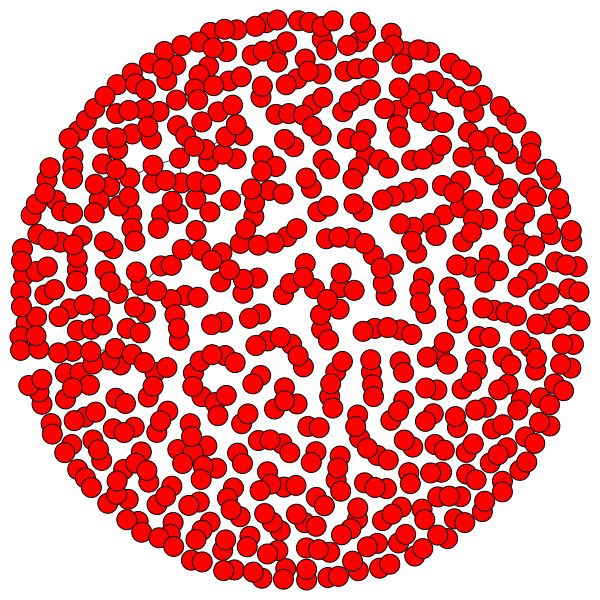

In [180]:
svs_approx['size'] = svs_approx['group'].apply(len)
svs_approx.query('fdr & size==2')

,group,pvalue,w,fdr,size
834,"(447, 835)",9.318866e-09,11,True,2
2728,"(89, 507)",1.801720e-12,11,True,2
3549,"(357, 605)",1.003334e-08,7,True,2
3594,"(351, 357)",4.589040e-17,13,True,2
3595,"(351, 605)",4.589040e-17,13,True,2
4750,"(379, 675)",1.324757e-12,11,True,2
6094,"(387, 462)",8.212937e-14,11,True,2
6727,"(644, 704)",9.997765e-08,9,True,2
7392,"(41, 682)",4.032482e-16,12,True,2
9480,"(66, 519)",1.370642e-09,8,True,2


In [162]:
len(list(filter(lambda x: len(x)==2,groups)))

48

In [164]:
groups

[(361, 562, 754),
 (342, 362, 442, 641, 708, 732),
 (73, 225, 628, 965),
 (80, 354, 442, 623, 946),
 (54, 217, 330, 338, 438, 614),
 (447, 835),
 (73, 225, 432, 965),
 (141, 563, 677, 725, 799, 902),
 (188, 365, 626, 848, 950),
 (456, 483, 564, 873, 902),
 (362, 442, 636, 641, 708, 732),
 (199, 475, 606),
 (279, 336, 337, 797),
 (199, 386, 390, 574, 778, 923),
 (89, 507),
 (223, 420, 617, 848),
 (53, 361, 668, 845),
 (53, 361, 580, 668),
 (357, 605),
 (65, 368, 647, 865, 877),
 (351, 357),
 (34, 426, 493, 550, 687),
 (188, 365, 626, 734, 848),
 (31, 193, 330, 843),
 (379, 675),
 (171, 633, 739, 971),
 (279, 835),
 (211, 502, 562),
 (60, 130, 358),
 (141, 538, 563, 725, 799, 902),
 (110, 306, 412, 629, 936),
 (142, 370, 403, 638),
 (387, 462),
 (383, 691, 910),
 (294, 404, 851),
 (141, 164, 644),
 (25, 354, 404, 582, 851, 901),
 (456, 483, 549, 564, 873),
 (342, 362, 442, 636, 641, 708),
 (41, 682),
 (199, 399, 606),
 (141, 538, 563, 677, 799, 902),
 (65, 368, 647, 877, 908),
 (176, 301

In [163]:
len(set(list(filter(lambda x: len(x)==2,groups))))

48

In [165]:
a = list(filter(lambda x: len(x)==2,groups))
(svs_approx.query('fdr & group in @a'))

,group,pvalue,w,fdr
834,"(447, 835)",9.318866e-09,11,True
2728,"(89, 507)",1.801720e-12,11,True
3549,"(357, 605)",1.003334e-08,7,True
3594,"(351, 357)",4.589040e-17,13,True
3595,"(351, 605)",4.589040e-17,13,True
4750,"(379, 675)",1.324757e-12,11,True
6094,"(387, 462)",8.212937e-14,11,True
6727,"(644, 704)",9.997765e-08,9,True
7392,"(41, 682)",4.032482e-16,12,True
9480,"(66, 519)",1.370642e-09,8,True


In [169]:
len(list(filter(lambda x: len(x)==2,groups))),len(svs_approx.query('fdr & size==2'))

(48, 41)

,group,pvalue,w,fdr,size
769,"(158, 396)",1.011184e-09,8,True,2
2971,"(179, 183)",9.002512e-08,6,True,2
4642,"(832, 985)",2.265305e-07,5,True,2
6163,"(954, 965)",4.686148e-08,6,True,2
6844,"(863, 868)",1.151118e-07,6,True,2
7718,"(205, 325)",8.087274e-08,8,True,2
9112,"(777, 965)",1.718751e-07,6,True,2
9202,"(466, 740)",3.804168e-08,7,True,2
9705,"(310, 602)",6.548606e-09,8,True,2
12214,"(93, 956)",4.965325e-08,8,True,2


In [161]:
tprs = []
fdrs = []
jaccards = []

for closure in np.linspace(0,1,6):
    
    print('#######################')
    print('Closure {}'.format(closure))

    df,groups = bench(N,k,max_order,closure,max_size=10,n_interactions=20)

    svs_approx = get_svs(df,approximate=True)
    true = groups
    pred = svs_approx.query('fdr').group
    tprs.append(tpr(true,pred))
    fdrs.append(fdr(true,pred))
    jaccards.append(jaccard(true,pred))

#######################
Closure 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
243
2425
10
10
9
8
7
6
5
4
3
2
#######################
Closure 0.2
2 0.2
3 0.18181818181818182
4 0.2
5 0.14285714285714285
6 0.16666666666666666
223
2204
10
10
9
8
7
6
5
4
3
2
#######################
Closure 0.4
2 0.4
3 0.36363636363636365
4 0.4
5 0.42857142857142855
6 0.3333333333333333
223
2203
10
10
9
8
7
6
5
4
3
2
#######################
Closure 0.6000000000000001
2 0.6
3 0.6363636363636364
4 0.6666666666666666
5 0.5714285714285714
6 0.6666666666666666
218
2122
10
10
9
8
7
6
5
4
3
2
#######################
Closure 0.8
2 0.8
3 0.8181818181818182
4 0.8888888888888888
5 0.8571428571428571
6 0.8333333333333334
218
2189
10
10
9
8
7
6
5
4
3
2
#######################
Closure 1.0
2 1.0
3 1.0
4 1.0
5 1.0
6 1.0
243
2486
10
10
9
8
7
6
5
4
3
2


(0.0, 1.0)

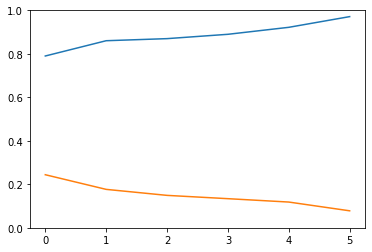

In [166]:
plt.plot(tprs)
plt.plot(fdrs)
plt.ylim([0,1])

(0.0, 1.0)

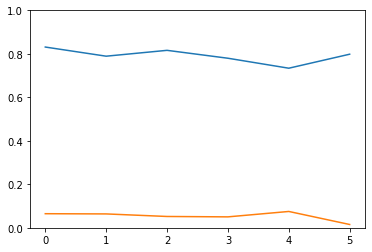

In [137]:
plt.plot(tprs)
plt.plot(fdrs)
plt.ylim([0,1])

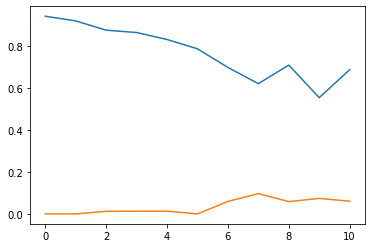

In [98]:
plt.plot(tprs)
plt.plot(fdrs)

In [116]:
import SVH

In [138]:
tprs_s = []
fdrs_s = []
jaccards_s = []

for closure in np.linspace(0,1,6):
    
    print('#######################')
    print('Closure {}'.format(closure))

    df,groups = bench(N,k,max_order,closure,max_size=10,n_interactions=10)

    svn = SVH.get_svn(df)
    true = groups
    pred = list(map(lambda x: tuple(sorted(x)),svn.maximal_cliques(min=2)))
    tprs_s.append(tpr(true,pred))
    fdrs_s.append(fdr(true,pred))
    jaccards_s.append(jaccard(true,pred))

#######################
Closure 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
243
#######################
Closure 0.2
2 0.2
3 0.18181818181818182
4 0.2
5 0.14285714285714285
6 0.16666666666666666
223
#######################
Closure 0.4
2 0.4
3 0.36363636363636365
4 0.4
5 0.42857142857142855
6 0.3333333333333333
223
#######################
Closure 0.6000000000000001
2 0.6
3 0.6363636363636364
4 0.6666666666666666
5 0.5714285714285714
6 0.6666666666666666
218
#######################
Closure 0.8
2 0.8
3 0.8181818181818182
4 0.8888888888888888
5 0.8571428571428571
6 0.8333333333333334
218
#######################
Closure 1.0
2 1.0
3 1.0
4 1.0
5 1.0
6 1.0
243


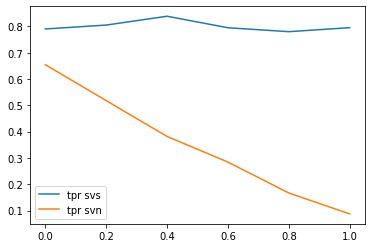

In [127]:
plt.plot(np.linspace(0,1,6),tprs,label='tpr svs')
plt.plot(np.linspace(0,1,6),tprs_s,label='tpr svn')
plt.legend()

(0.0, 1.0)

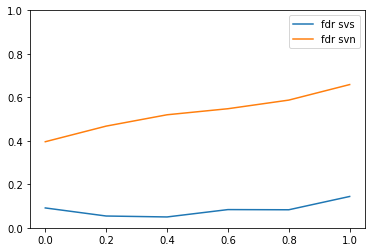

In [128]:
plt.plot(np.linspace(0,1,6),fdrs,label='fdr svs')
plt.plot(np.linspace(0,1,6),fdrs_s,label='fdr svn')
plt.legend()
plt.ylim([0,1])

In [53]:
true_groups = pd.DataFrame()
true_groups['group'] = groups
true_groups['size'] = true_groups.group.apply(len)
true_groups.groupby('size').count()

,group
size,
2,99
3,100
4,100
5,96
6,98


In [54]:
max_size = 10
n_interactions = 10

interactions = []
for g in groups:
    for _ in range(st.binom.rvs(p=.5,n=n_interactions)):
        size = np.random.choice(range(1,max_size+1-len(g)))
        print(size)
        interactions.append(g+tuple(np.random.choice(list(set(range(N)).difference(g)),replace=False,size=size)))

8
6
8
6
2
3
3
6
2
8
1
2
7
5
7
5
6
3
3
7
7
7
3
2
7
2
4
3
4
6
7
7
8
1
7
7
4
5
1
3
4
3
4
4
7
7
4
8
8
8
8
8
3
6
6
6
8
4
4
5
2
2
3
7
5
7
5
1
3
6
8
5
1
1
7
8
2
5
2
5
7
5
1
4
2
6
5
3
8
8
8
2
3
4
7
3
1
6
2
6
5
1
4
6
6
7
2
2
4
3
7
5
5
6
6
6
1
2
1
5
7
3
4
6
6
3
8
1
3
8
8
1
6
3
4
5
4
5
3
1
1
3
2
5
3
5
3
4
2
5
7
5
4
1
3
6
5
4
8
6
6
4
8
1
1
5
2
6
2
8
1
3
2
8
4
3
7
3
6
8
7
2
4
2
8
8
1
4
3
6
4
2
3
3
5
1
1
7
7
7
2
6
8
5
8
1
2
6
4
8
1
2
4
6
3
1
7
7
4
7
5
6
4
1
1
4
8
2
2
3
3
8
2
1
4
2
5
4
6
7
5
6
1
1
3
5
7
6
1
4
3
7
1
7
8
3
1
6
4
8
5
3
5
3
4
7
6
5
1
5
2
2
5
5
7
2
1
2
7
4
7
2
1
4
4
4
3
1
5
2
2
5
7
6
2
8
1
7
2
6
4
2
2
1
6
8
5
3
5
4
3
7
5
1
5
4
4
7
5
8
4
7
7
6
1
6
5
4
8
7
2
8
8
1
1
1
6
4
3
7
8
7
8
3
4
7
3
2
7
1
4
2
1
1
1
6
5
4
4
3
7
7
3
4
7
5
7
1
8
4
8
3
4
5
8
6
5
5
3
8
1
3
3
4
5
3
6
4
8
7
1
3
1
4
7
8
6
5
8
8
1
1
8
1
3
4
2
5
8
4
8
7
4
1
6
6
1
3
6
2
6
3
1
4
7
7
2
6
2
1
7
1
6
7
1
5
4
6
7
6
3
6
3
3
2
7
1
2
8
7
6
1
3
6
1
8
4
8
4
8
5
1
6
1
1
8
3
6
7
1
8
7
7
8
6
8
6
5
5
6
8
8
3
2
8
6
5
2
1
7
6
6
7
4
4
4
2
1
6
4


In [55]:
edges = []

M = N

for clique in interactions:
    for t in clique:
        edges.append((t,M))
    M+=1

df = pd.DataFrame(edges,columns=['a','b'])

In [56]:
svs_approx = get_svs(df,approximate=True)

2447
10
10
9
8
7
6
5
4
3
2


(0.9188640973630832, 0.0022026431718061676, 0.917004048582996)

In [51]:
N = 10000
k=100
max_order = 6
closure = 0.5

groups = []
for order in range(2,max_order+1):

    kk = int(k/binom(order+1,order))
    print(kk)
    if np.random.rand()>1-closure:
        group.append(
    groups.extend(list(map(lambda x: tuple(sorted(x)),[np.random.choice(range(N),replace=False,size=order) for _ in range(k)])))
    
print(len(groups))
for order in range(2,max_order+1):
    larger_g = set()
    for l in map(lambda x: tuple(combinations(x,order)),filter(lambda x: len(x)>order,groups)):
        for g in l: larger_g.add(g)
    groups = list(filter(lambda x: not (x in larger_g),groups ))
    
groups = list(set(groups))

SyntaxError: '(' was never closed (3737517456.py, line 12)

In [22]:
max_size = 10
n_interactions = 10

interactions = []
for g in groups:
    for _ in range(st.binom.rvs(p=.5,n=n_interactions)):
        size = np.random.choice(range(1,max_size+1-len(g)))
        print(size)
        interactions.append(g+tuple(np.random.choice(list(set(range(N)).difference(g)),replace=False,size=size)))

4
6
6
4
6
5
5
7
3
1
1
7
3
4
2
5
1
1
2
8
4
5
1
6
6
2
1
5
4
3
6
2
1
2
1
5
4
3
4
4
1
3
3
1
3
7
7
2
2
1
7
4
3
3
2
3
1
1
4
4
5
5
5
4
4
1
3
3
2
5
1
1
2
6
7
8
1
7
5
4
5
2
5
4
2
1
1
4
3
2
3
1
1
2
2
7
2
1
5
4
4
1
3
3
1
6
1
3
1
3
3
5
4
2
2
6
3
4
2
4
5
4
3
6
5
5
4
6
2
5
4
3
1
2
5
6
4
1
3
3
1
6
1
6
7
3
5
8
5
1
7
5
4
6
6
7
5
5
5
4
1
1
2
7
6
4
3
4
3
4
5
5
2
4
1
4
1
1
3
4
1
2
1
3
1
2
2
2
6
6
2
5
1
4
2
4
1
2
2
4
3
4
4
5
3
4
1
4
2
3
3
2
1
5
6
3
5
2
4
3
3
6
1
3
4
1
1
1
2
3
1
2
4
4
3
3
6
5
1
3
4
3
4
1
1
7
7
4
2
3
6
1
1
3


In [24]:
svs_approx = get_svs(df,approximate=True)

254
10
10
9
8
7
6
5
4
3
2


In [50]:


true = groups
pred = svs_approx.query('fdr').group
tpr(true,pred),fdr(true,pred),jaccard(true,pred)

(0.9594320486815415, 0.012526096033402923, 0.9478957915831663)

In [34]:


true = groups
pred = svs_approx.query('fdr').group
tpr(true,pred),fdr(true,pred),jaccard(true,pred)

(0.8, 0.024390243902439025, 0.7843137254901961)